In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from numpy.random import SeedSequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pyselect.datasets import make_gregorova_se1, make_gregorova_se2, make_jordan_se1
from pyselect.model import RFFNet

# Solvers

In [2]:
def prox_2_squared(x, alpha):
    "Proximal operator for l2 norm squared."
    return x / (1 + 2 * alpha)

In [3]:
def adam_palm():
    torch.manual_seed(SEED)
    model = RFFNet(dims=[n_features, n_random_features, 1])

    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=LR)
    optim_rff = torch.optim.Adam(model.rff.parameters(), lr=LR)

    model.train()

    history = []

    for epoch in range(N_EPOCHS):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // BATCH_SIZE):
            batch = indices[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, ALPHA * curr_lr
                )

        for i in range(train_size // BATCH_SIZE):
            batch = indices[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = CRITERION(model(X_val), y_val)
            history.append(val_loss)

    return history

In [4]:
def sgd_palm():
    torch.manual_seed(SEED)
    model = RFFNet(dims=[n_features, n_random_features, 1])

    optim_linear = torch.optim.SGD(model.linear.parameters(), lr=LR)
    optim_rff = torch.optim.SGD(model.rff.parameters(), lr=LR)

    model.train()

    history = []

    for epoch in range(N_EPOCHS):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // BATCH_SIZE):
            batch = indices[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, ALPHA * curr_lr
                )

        for i in range(train_size // BATCH_SIZE):
            batch = indices[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = CRITERION(model(X_val), y_val)
            history.append(val_loss)

    return history

In [5]:
def sgd_vanilla():
    torch.manual_seed(SEED)
    model = RFFNet(dims=[n_features, n_random_features, 1])

    optim = torch.optim.SGD(model.parameters(), lr=LR)

    model.train()

    history = []

    for epoch in range(N_EPOCHS):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // BATCH_SIZE):
            batch = indices[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim.zero_grad()
            loss.backward()
            optim.step()

            with torch.no_grad():
                curr_lr = optim.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, ALPHA * curr_lr
                )

        with torch.no_grad():
            val_loss = CRITERION(model(X_val), y_val)
            history.append(val_loss)

    return history

In [6]:
def adam_vanilla():
    torch.manual_seed(SEED)
    model = RFFNet(dims=[n_features, n_random_features, 1])

    optim = torch.optim.Adam(model.parameters(), lr=LR)

    model.train()

    history = []

    for epoch in range(N_EPOCHS):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // BATCH_SIZE):
            batch = indices[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim.zero_grad()
            loss.backward()
            optim.step()

            with torch.no_grad():
                curr_lr = optim.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, ALPHA * curr_lr
                )

        with torch.no_grad():
            val_loss = CRITERION(model(X_val), y_val)
            history.append(val_loss)

    return history

## Randomness

In [7]:
seed_sequence = SeedSequence(entropy=0)

In [8]:
SEED = seed_sequence.generate_state(1)[0]

## Data

In [9]:
n_samples = 6 * 10 ** 3
train_size = 5 * 10 ** 3

## Run

In [10]:
n_random_features = 200

In [11]:
N_EPOCHS = 100
LR = 1e-2
BATCH_SIZE = 250
ALPHA = 1e-1
CRITERION = torch.nn.MSELoss()

In [12]:
palm_adam_hist = []
palm_sgd_hist = []
adam_hist = []
sgd_hist = []

In [13]:
for gen in [make_jordan_se1, make_gregorova_se1, make_gregorova_se2]:
    X, y = gen(n_samples=n_samples, random_state=SEED)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, train_size=train_size, random_state=SEED
    )
    n_features = X.shape[1]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    y_train = torch.FloatTensor(y_train)
    y_val = torch.FloatTensor(y_val)
    
    palm_adam_hist.append(adam_palm())
    palm_sgd_hist.append(sgd_palm())
    adam_hist.append(adam_vanilla())
    sgd_hist.append(sgd_vanilla())

## Plot

In [14]:
CMAP = plt.cm.plasma
CMAP_R = plt.cm.plasma_r
COLORS = [CMAP(i / 4.0) for i in range(5)]

In [15]:
COLOR_0 = COLORS[0]
COLOR_1 = COLORS[1]
COLOR_2 = COLORS[2]
COLOR_3 = COLORS[3]

In [16]:
TEXTWIDTH = 3.25063
FONTSIZE = 6

In [20]:
def setup():
    matplotlib.rcParams.update({"font.size": FONTSIZE})  # controls default text sizes
    matplotlib.rcParams.update({"axes.titlesize": FONTSIZE})  # fontsize of the axes title
    matplotlib.rcParams.update({"axes.labelsize": FONTSIZE})  # fontsize of the x and y labels
    matplotlib.rcParams.update({"axes.formatter.use_mathtext": True})  # use scientific notation for axes with pretty formatting
    matplotlib.rcParams.update({"axes.formatter.useoffset": True}) #
    matplotlib.rcParams.update({"axes.formatter.limits": [0, 0]})  
    matplotlib.rcParams.update({"xtick.labelsize": FONTSIZE})  # fontsize of the tick labels
    matplotlib.rcParams.update({"ytick.labelsize": FONTSIZE})  # fontsize of the tick labels
    matplotlib.rcParams.update({"legend.fontsize": FONTSIZE})  # legend fontsize
    matplotlib.rcParams.update({"figure.titlesize": FONTSIZE})  # fontsize of the figure title
    matplotlib.rcParams.update({"figure.dpi": 300})
    matplotlib.rcParams.update({"savefig.dpi": 300})

In [21]:
setup()

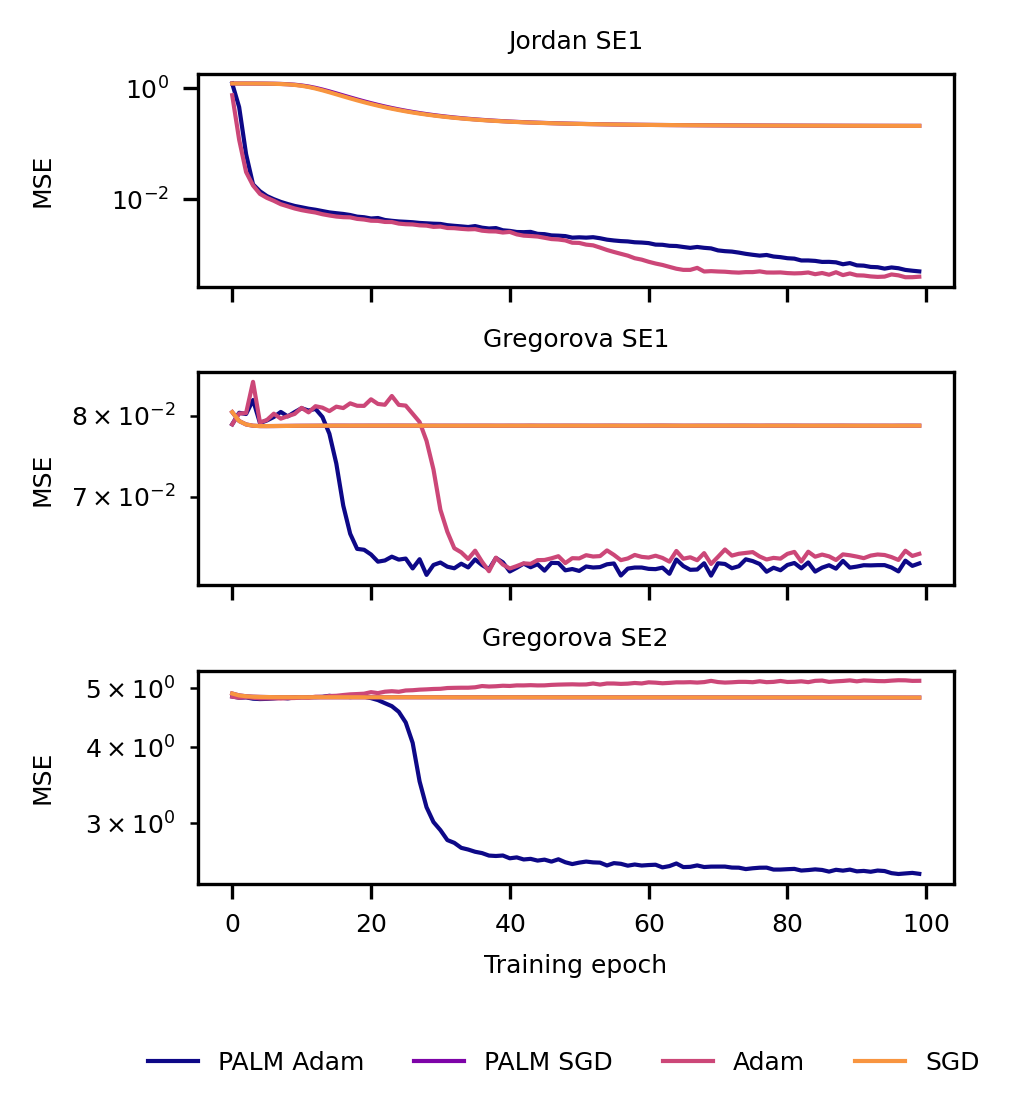

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(TEXTWIDTH, TEXTWIDTH*1.1))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
ax1.plot(palm_adam_hist[0], lw=1, color=COLOR_0, label="PALM Adam")
ax1.plot(palm_sgd_hist[0], lw=1, color=COLOR_1, label="PALM SGD")
ax1.plot(adam_hist[0], lw=1, color=COLOR_2, label="Adam")
ax1.plot(sgd_hist[0], lw=1, color=COLOR_3, label="SGD")
ax1.set_yscale("log")
ax1.set_title("Jordan SE1")
ax1.set_ylabel("MSE")

ax2.plot(palm_adam_hist[1], lw=1, color=COLOR_0, label="PALM Adam")
ax2.plot(palm_sgd_hist[1], lw=1, color=COLOR_1, label="PALM SGD")
ax2.plot(adam_hist[1], lw=1, color=COLOR_2, label="Adam")
ax2.plot(sgd_hist[1], lw=1, color=COLOR_3, label="SGD")
ax2.set_yscale("log")
ax2.set_title("Gregorova SE1")
ax2.set_ylabel("MSE")

ax3.plot(palm_adam_hist[2], lw=1, color=COLOR_0, label="PALM Adam")
ax3.plot(palm_sgd_hist[2], lw=1, color=COLOR_1, label="PALM SGD")
ax3.plot(adam_hist[2], lw=1, color=COLOR_2, label="Adam")
ax3.plot(sgd_hist[2], lw=1, color=COLOR_3, label="SGD")
ax3.set_yscale("log")
ax3.set_xlabel("Training epoch")
ax3.ticklabel_format(style="plain", axis="x")
ax3.set_title("Gregorova SE2")
ax3.set_ylabel("MSE")

lines_labels = [ax1.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.01), ncols=4, frameon=False)

fig.align_ylabels()

plt.savefig("../figures/validation/solvers.pdf", bbox_inches="tight")

plt.show()